# Contextually Supervised Source Separation (CSSS)
This packages deploys contextually supervised source separation (CSSS) techniques in python. CSSS was originally decribed by Wytock and Kolter in [1] and we follow their original notation in this docuemntation.  We also include updates and extensions of the origianl CSSS method as created by the authors of this package in their applied work [2-4]. 	

CSSS is the disaggregation of a time series of source signals from observations of their sum. The below equation displays this problem where the vector $\bar y$ is observed and each source signal, $y_i$ is unobserved. 
\begin{equation}
\bar y = \sum_{i=0}^{k} y_i
\end{equation}

Contextual separation is achieved by (A) relating each source signal to exogenous observations, and (B) exploiting known regularity in the source signals. 
The equation below displays the general form of this optimization as presented in [1]. $\ell_i()$ is a cost function to fit the source signal, $y_i$ to the exogenous variables, $X_i$, using a linear transformation with parameters $\theta_i$; $g_i()$ is a regularization term applied to the source signal which would elicit smoothness or other periodic regularity; and $h_i()$ is a regularization term for the parameters $\theta_i$. 

\begin{align}
\min_{Y,\theta}\hspace{5mm}& \sum_{i=0}^{k} \{ \ell_i(y_i, X_i \theta_i) + g_i(y_i) + h_i(\theta_i)\}\\
\mbox{s.t.,}\hspace{5mm}&  \bar y = \sum_{i=0}^{k} y_i
\end{align}


In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cvxpy 
import CSSS as CSSS
import time 
%matplotlib inline

# Tutorial Data
We generate a basic set of data for this tutorial. 
The source signals, Y1 and Y2 are constucted by adding white noise to univariate context variables: X1, and X2. 
- X1 contains a sin wave (period 10, amplitude 50) and an intercept term of 10. 
- X2 is a trend that increases linearly with time. 

In [75]:
## Create an example case where we separate two signals based on sin functions. 
N = 10

X12 = np.sin(np.arange(N)*2*np.pi/N)*50 
X11 = np.ones(N)
X1  = np.vstack([X11,X12]).transpose()
Y1  = X1[:,0] * 10 + X1[:,1] + np.random.normal(0,4,N) 


X2 = np.array([5*elem+2 for elem in range(0,N)])
Y2 = X2 + np.random.normal(0,5,N)

Y = Y1 + Y2 


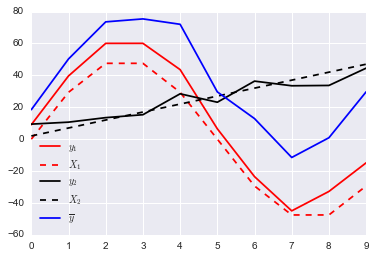

In [76]:
plt.plot(Y1, 'r',   label='$y_1$')
plt.plot(X1[:,1], 'r--', label='$X_1$')
plt.plot(Y2, 'k',   label='$y_2$',)
plt.plot(X2, 'k--', label='$X_2$')


plt.plot(Y,'b',label='$\overline{y}$')
plt.legend(loc = 3)


## CSSS Object
The CSSS package is built upon the CSSS object class, which allows users to fully specifcy and fit a problem. 

A CSSS objest is initailized with only a source signal for disaggregation, in this case the numpy array, Y. 


### Attributes
- `models` is a dictionary of models for each component sources.  Adding sources and their properties are addressed below. 
- `constraints` is a list of additional constraints. Adding constraints is addressed below. 
- `aggregateSignal` is the aggregate signal
- `N` is the number of observations in the aggregate signal. 
- `modelcounter` is the total number of source models included.


In [77]:
CSSEtry = CSSS.CSSS(Y)

### Adding Sources
The method CSSS.addSource adds a model for a source signal. By default, the model cost function is the sum of square errors, $\left|\left| y_i - X_i \theta_i \right|\right|_2^2$_, and there is no regularization of the source signal or the parameters. Alternate options for this form (i.e. other norms) will be included in future versions of this package. 
```python
CSSSobject.addSource(X1, name = 'y1')  ## Add a model for source signal y1
CSSSobject.addSource(X2, name = 'y2')  ## Add a model for source signal y2
```
The optional parameter `alpha` is a salar that weights the cost of the signal in the objective function. In the following example, costs associated with the errors in the model for `y1` will be weighted twice that of those for `y2`. 


In [78]:
# Try it out. 
CSSEtry = CSSS.CSSS(Y)  ## Instantiate model with aggregate signal, Y
CSSEtry.addSource(X1, alpha = 1, name = 'Y1')  ## Add a model for Y1
CSSEtry.addSource(X2, alpha = 1, name = 'Y2')  ## Add a model for Y2

## Constrain Y2 to be greater than -1 just to try out the constraints. 
#CSSEtry.addConstraint(CSSEtry.models['Y2']['source'] > -10 )
start=time.time()
CSSEtry.constructSolve()
print(time.time()-start)


Setting theta reg cost to 0
Setting theta reg cost to 0
0.0131690502167


#### Parameter Regularization
The `regularizeTheta` input to `addSource` defines the $h_i()$ term for the source and takes either a string or a function. Strings define standard regularizations and can take "ss" for sum of squares, 'l1' for l1-norms, and 'l2' for l2-norms. `beta` is a parameter for linearly scaling the regularization term in the overall objective function. `beta` may take a scalar or a vector value, if a vector there must be one element for element of $\theta_i$.



If inputing a custom function to regularize theta, the function must input a vector of cvxpy variables, and output a scalar that goes into the objective function, and must be convex. The `beta` term can still be used to scale this function. 
```python
import cvxpy




In [79]:
def customReg(x):
    cvxpy.sum_entries(cvxpy.power((x-2),2))

CSSEtry = CSSS.CSSS(Y)  ## Instantiate model with aggregate signal, Y
CSSEtry.addSource˜(X2, alpha = 1, name = 'Y2')  ## Add a model for Y2
CSSEtry.addSource(X1, name = 'y1', regularizeTheta=customReg)  ## Add a model for source signal y1


Setting theta reg cost to 0


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [ ]:
import time
start=time.time()
[dual_obj,norm_resid_equality,u]=CSSEtry.admmSolve(10, MaxIter=100, ABSTOL=0.001, RELTOL=0.01,verbose=True)
print(time.time()-start)

In [ ]:
plt.plot(CSSEtry.models['Y1']['source'].value, label = 'Disaggregated')

#plt.plot(CSSEtry.models['Y1']['regressor'] * CSSEtry.models['Y1']['theta'].value, label = 'Modeled')
plt.plot(Y1, label = 'Actual')
plt.plot(CSSEtry.models['Y1']['admmSource'], label = 'ADMMDisaggregated')

plt.legend()
plt.show()

In [ ]:
plt.plot(CSSEtry.models['Y2']['source'].value, label = 'Disaggregated')

#plt.plot(CSSEtry.models['Y2']['regressor'] * CSSEtry.models['Y2']['theta'].value, label = 'Modeled')
plt.plot(Y2, label = 'Actual')
plt.plot(CSSEtry.models['Y2']['admmSource'], label = 'ADMMDisaggregated')

plt.legend()
plt.show()

In [ ]:
plt.plot(Y, label = 'Actual Total')
plt.plot(CSSEtry.models['Y2']['source'].value+CSSEtry.models['Y1']['source'].value, '--<r',label = 'CSSS Total',)
plt.plot(CSSEtry.models['Y2']['admmSource']+CSSEtry.models['Y1']['admmSource'],'--ob', label = 'ADMM total',)

plt.legend()
plt.show()

In [ ]:
plt.plot(CSSEtry.models['Y2']['admmSource'], label = 'ADMMDisaggregated')
plt.plot(CSSEtry.models['Y1']['admmSource'], label = 'ADMMDisaggregated')
